In [367]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import minimize
from scipy.spatial.distance import directed_hausdorff

Import the given data and plot it

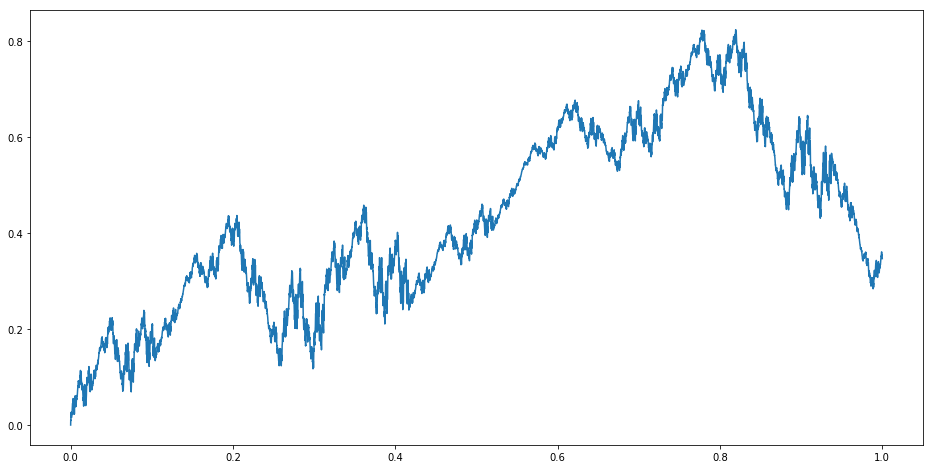

In [9]:
A_data = np.load('A.npy')
b_data = np.load('b.npy')
d_data = np.load('d.npy')

data_full = np.load('rough_data.npy')
data = data_full[data_full[:,0]<=1,:]

plt.figure(figsize=(16,8))
plt.plot(data[:,0],data[:,1])

Make a function that finds a FIF for a given data set

In [11]:
def inter_gen(X,Y,d,inc_a = False):
    
    '''
    input:
    Y,X    - N+1 by 1 numpy array as data points
    d      - N by 1 numpy array as votility factors
    '''
    
    assert(X.shape == Y.shape)
    
    n = X.shape[0]
    
    N = d.shape[0]
    
    assert(n-1 == N)
    
    A = []
    
    b = []
    
    a = []
    
    for i in range(1,n):
        
        A.append(np.array([[ X[i] - X[i-1], 0  ], [Y[i] - Y[i-1] - d[i-1]*Y[-1], d[i-1]]  ] ,dtype=float))
        
        b.append(np.array([  X[i-1]  , Y[i-1]  ],dtype=float).reshape((2,1)))
        
        a.append(X[i] - X[i-1])
        
    #if you want to return the a values for dimension calculations
    if inc_a:
        
        return A,b,a
        
    return A,b 

An implimentation of the Chaos game for Affine maps

In [20]:
def chaos(A,b,p = None ,it =100,burn = 5):
    
    '''
    Implimentation of the Chaos game for affine maps
    Imput:
    A    - n by n matrix for IFS
    b    - n by 1 matrix for IFS
    p    - probabilities for maps
    
    '''
    
    assert(len(A) == len(b))
    
    N = len(A)
    
    #assign uniform probabilites if not specified
    if p == None:
        
        p = np.ones(N)/N
    
    
    z = np.random.rand(2).reshape([2,1])
    
    Z = np.zeros((it,2))
    
    for i in range(it):
        
        prob = np.random.rand()
        
        P = 0
        
        for q in range(N):
            
            P += p[q]
            
            if prob < P:
                
                
                z = A[q]@z + b[q]
                
                if i>burn:
                    
                    Z[i,:] = z.flatten()
                
                break
                
    return Z

Make a function that evaluates the constants given in the tex document

In [131]:
def cons(X,Y,Sx,Sy,i):
    
    '''
    input:
    Y,X    - n by 1 numpy array as data points
    Sx,Sy  - N by 1 locations of the interpolation points
    i      - which partition wants to be calculated
    '''
    
    
    Z = X[(Sx[i]>X)*(X>Sx[i-1])]
    
    W = Y[(Sx[i]>X)*(X>Sx[i-1])]
    
    c0 = 0
    
    c1 = 0
    
    c2 = 0
    
    for j in range(len(Z)):
        
        c0 += (Sy[i-1] + ((Z[j]-Sx[i-1])*(Sy[i]-Sy[i-1]))/(Sx[i]-Sx[i-1]) - W[j])**2
        
        c1 += 2*(Sy[i-1] + ((Z[j]-Sx[i-1])*(Sy[i]-Sy[i-1]))/(Sx[i]-Sx[i-1]) - W[j])*(Sy[-1]*((Z[j]-Sx[i-1])/(Sx[i]-Sx[i-1])) - Y[np.abs(X - (Z[j]-Sx[i-1])/(Sx[i]-Sx[i-1])  ).argmin() ] )
        
        c2 += (Sy[-1]*((Z[j]-Sx[i-1])/(Sx[i]-Sx[i-1])) - Y[np.abs(X - (Z[j]-Sx[i-1])/(Sx[i]-Sx[i-1])  ).argmin() ] )**2
        
    
    return c0,c1,c2


Function that finds the optimal $d_i$ that in unconstrained

In [294]:
def find_d_i(X,Y,Sx,Sy,i):
    
    c0,c1,c2 = cons(X,Y,Sx,Sy,i)
    
    return 0.5*c1/c2

Example provided in thesis

In [435]:
X_ex = np.array([0,0.1   ,0.5,0.6,1]).reshape((5,1))
Y_ex = np.array([0,-0.1  ,1  ,1  ,0]).reshape((5,1))
Sx_ex = np.array([0,0.1,1]).reshape((3,1))
Sy_ex = np.array([0,-0.1,0]).reshape((3,1))
cons(X_ex,Y_ex,Sx_ex,Sy_ex,2)
find_d_i(X_ex,Y_ex,Sx_ex,Sy_ex,2)

array([1.05])

Function that selects a subset of $n$ points

In [384]:
def red_res(n,Z):
    
    res = np.linspace(0,1,n+1)
    
    boo = (Z[:,0]==0)
    
    for i in range(1,len(res)):
        
        boo += (Z[:,0]==min(Z[:,0], key=lambda x:abs(x-res[i])))
                   
    return  Z[boo,:]

Function that finds the unconstrained solution to the optimisation

In [385]:
def uncon_sol(data,N):
    
    S = red_res(N,data)

    Sx = S[:,0]

    Sy = S[:,1]

    Xd = data[:,0]

    Yd = data[:,1]
    
    d = np.zeros((len(Sx)-1,1))

    c = np.zeros((len(Sx)-1,3))

    for i in range(1,len(Sx)):
        
        di = find_d_i(Xd,Yd,Sx,Sy,i)

        d[i-1] = np.sign(di)*np.min([np.abs(di),0.95])

        c[i-1,:] =  cons(Xd,Yd,Sx,Sy,i)

    return Sx,Sy,d,c

Unconstrained solution with 16 maps

In [387]:
Sx,Sy,d_un,c_un = uncon_sol(data,16)
s = np.sign(d_un)
d_un

array([[ 0.25107463],
       [-0.02708155],
       [-0.01287294],
       [ 0.08754844],
       [-0.097674  ],
       [ 0.31655053],
       [-0.02924108],
       [-0.01322763],
       [-0.07045796],
       [ 0.0328213 ],
       [-0.1909197 ],
       [-0.09893547],
       [-0.01666951],
       [ 0.04348496],
       [-0.08118093],
       [-0.19134702]])

In [388]:
def obj_fun_un(d):
    return np.dot(c_un[:,2],d**2) - np.dot(c_un[:,1],d) + np.sum(c_un[:,0])

def obj_der_un(d):
    return 2*d*c_un[:,2]-c_un[:,1]

Check this is correct with a numerical optimiser

In [389]:
x0 = np.zeros(len(d_un))
res_un = minimize(obj_fun_un, x0, jac=obj_der_un )

Is correct

In [391]:
print(res_un.x)
print(d_un.flatten())

[ 0.25107463 -0.02708155 -0.01287294  0.08754844 -0.097674    0.31655053
 -0.02924108 -0.01322763 -0.07045796  0.0328213  -0.1909197  -0.09893547
 -0.01666951  0.04348496 -0.08118093 -0.19134702]
[ 0.25107463 -0.02708155 -0.01287294  0.08754844 -0.097674    0.31655053
 -0.02924108 -0.01322763 -0.07045796  0.0328213  -0.1909197  -0.09893547
 -0.01666951  0.04348496 -0.08118093 -0.19134702]


Plot unconstrained solution with initial data

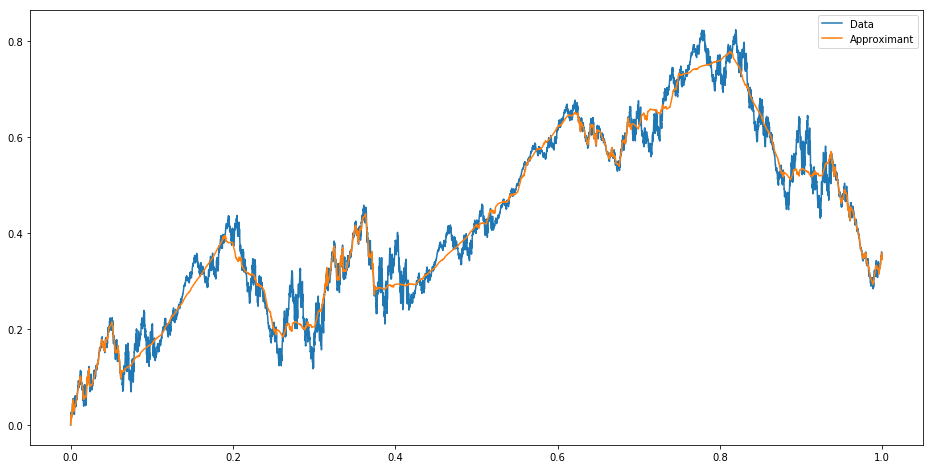

In [437]:
A_un, b_un , a_un= inter_gen(Sx,Sy,d_un, inc_a = True)
app_un = chaos(A_un, b_un ,p = None ,it =10000)
app_un = app_un[app_un[:,0].argsort()]
plt.figure(figsize=(16,8))
plt.plot(data[:,0],data[:,1], label = 'Data')
plt.plot(app_un[:,0],app_un[:,1],label = 'Approximant')
plt.legend()

In the example above, the approximant does a good job at describing the data in the $L^2$ sense. However, it does not capture the `fractal' nature of the object as evinced through the following calculation.

In [438]:
def dims(a,d,D):
    d0 = d.flatten()
    aD = np.power(a,D-1)
    return np.dot(d0.flatten(),aD.flatten())-1

In [443]:
minimize( lambda x : (dims(a_un,np.abs(d_un),x))**2, 1.5).x

array([1.16063787])

The dimension from this descriptive model is nothing near the actual dimension of the data of approximately $1.538$. The following approximant will match this dimension.

In [446]:
D_approx  = 1.538

C = c_un[:,1]*s.flatten()

K = np.power(a_un,D_approx-1)

def obj_fun(d):
    return np.dot(c_un[:,2],d**2) - np.dot(C,d) + np.sum(c_un[:,0])

def obj_der(d):
    return 2*d*c_un[:,2]-C

ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.hstack([(x.flatten()),(1-x.flatten())]) ,
             'jac' : lambda x: np.vstack([np.diag(np.abs(s).flatten()),np.diag(-np.abs(s).flatten())])}
eq_cons = {'type': 'eq',
           'fun' : lambda x: np.array([dims(np.array(a_un),x,D_approx)]),
           'jac' : lambda x: K }

In [447]:
x0 = x0 = np.abs(d_un)
res = minimize(obj_fun, x0, method='SLSQP', jac=obj_der,constraints=[eq_cons, ineq_cons] ,options={'ftol': 1e-9, 'disp': True})
print(d_un.flatten())
print(res.x*s.flatten())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 34.43859959182272
            Iterations: 3
            Function evaluations: 5
            Gradient evaluations: 3
[ 0.25107463 -0.02708155 -0.01287294  0.08754844 -0.097674    0.31655053
 -0.02924108 -0.01322763 -0.07045796  0.0328213  -0.1909197  -0.09893547
 -0.01666951  0.04348496 -0.08118093 -0.19134702]
[ 0.43128383 -0.20729075 -0.19308214  0.26775764 -0.27788321  0.49675974
 -0.20945028 -0.19343683 -0.25066716  0.21303051 -0.3711289  -0.27914468
 -0.19687871  0.22369417 -0.26139014 -0.37155622]


In [448]:
A_con, b_con = inter_gen(Sx,Sy,res['x']*s.flatten())
Z_con = chaos(A_con, b_con ,p = None ,it =10000)

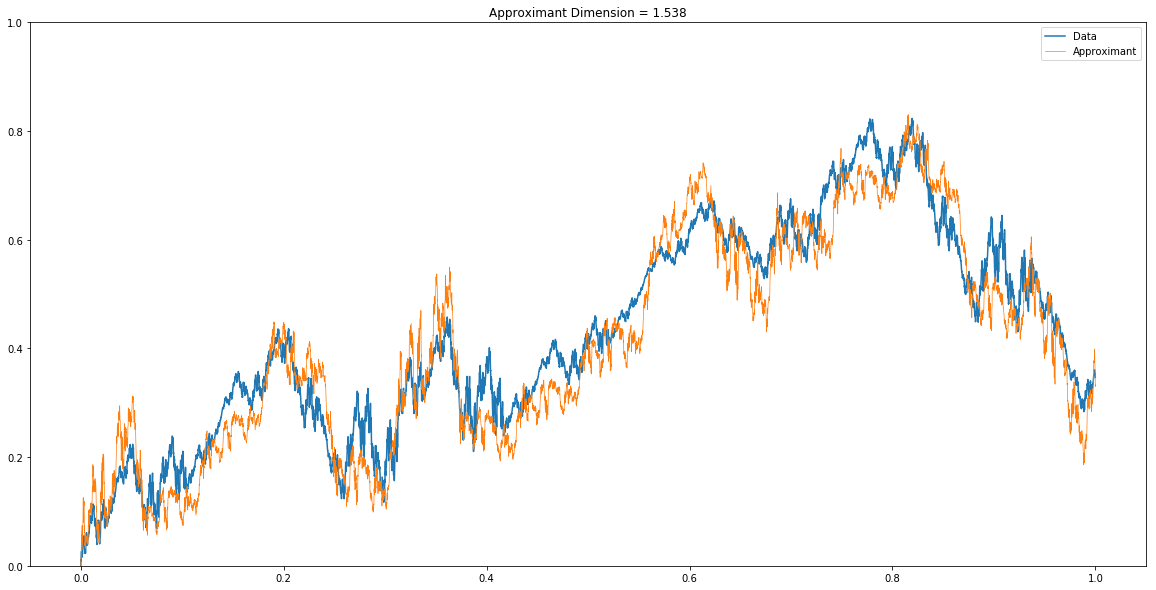

In [449]:
Z_con = Z_con[Z_con[:,0].argsort()]

plt.figure(figsize = (20,10))

plt.plot(data[:,0],data[:,1], label = 'Data')

plt.ylim(0,1)
plt.plot(Z_con[:,0],Z_con[:,1], label = "Approximant",linewidth = 0.7)
plt.title("Approximant Dimension = " + str(D_approx))
plt.legend()

This approximation `looks' good by being close in the $L^2$ sense and matching the dimension of the data. The Hausdorff distance between these two can be calculated.

In [450]:
max(directed_hausdorff(data,Z_con)[0], directed_hausdorff(Z_con,data)[0])

0.09820710413621062

Putting the above working into a single function yields:

In [451]:
def novel_apx(data,N,D):
    
    Sx,Sy,d_un,c_un = uncon_sol(data,N)
    s = np.sign(d_un)
    
    if D == 0:
        
        A,b = inter_gen(Sx,Sy,d_un)
        
        return A,b
    
    a_un = np.ones(N)/N
    
    def dims(a,d,D,s):
        d0 = d.flatten()
        aD = np.power(a,D-1)
        return np.dot(d0.flatten(),aD.flatten())-1
    
    D_approx = D
    
    C = c_un[:,1]*s.flatten()

    K = np.power(a_un,D_approx-1)

    def obj_fun(d):
        return np.dot(c_un[:,2],d**2) - np.dot(C,d) + np.sum(c_un[:,0])

    def obj_der(d):
        return 2*d*c_un[:,2]-C

    ineq_cons = {'type': 'ineq',
                 'fun' : lambda x: np.hstack([(x.flatten()),(1-x.flatten())]) ,
                 'jac' : lambda x: np.vstack([np.diag(np.abs(s).flatten()),np.diag(-np.abs(s).flatten())])}
    eq_cons = {'type': 'eq',
               'fun' : lambda x: np.array([dims(np.array(a_un),x,D_approx,s)]),
               'jac' : lambda x: K }
    
    
    x0 = x0 = np.abs(d_un)
    res = minimize(obj_fun, x0, method='SLSQP', jac=obj_der,constraints=[eq_cons, ineq_cons] ,options={'ftol': 1e-9, 'disp': True})
    
    A, b = inter_gen(Sx,Sy,res['x']*s.flatten())
    
    print('d values:')
    print(res['x']*s.flatten())
    
    return A,b

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.023215390945822
            Iterations: 3
            Function evaluations: 5
            Gradient evaluations: 3
d values:
[ 0.40350665 -0.17951357 -0.16530496  0.23998046 -0.25010602  0.46898256
 -0.1816731  -0.16565965 -0.22288998  0.18525332 -0.34335172 -0.2513675
 -0.16910153  0.19591699 -0.23361295 -0.34377904]
Hausdorff Distance:
0.08


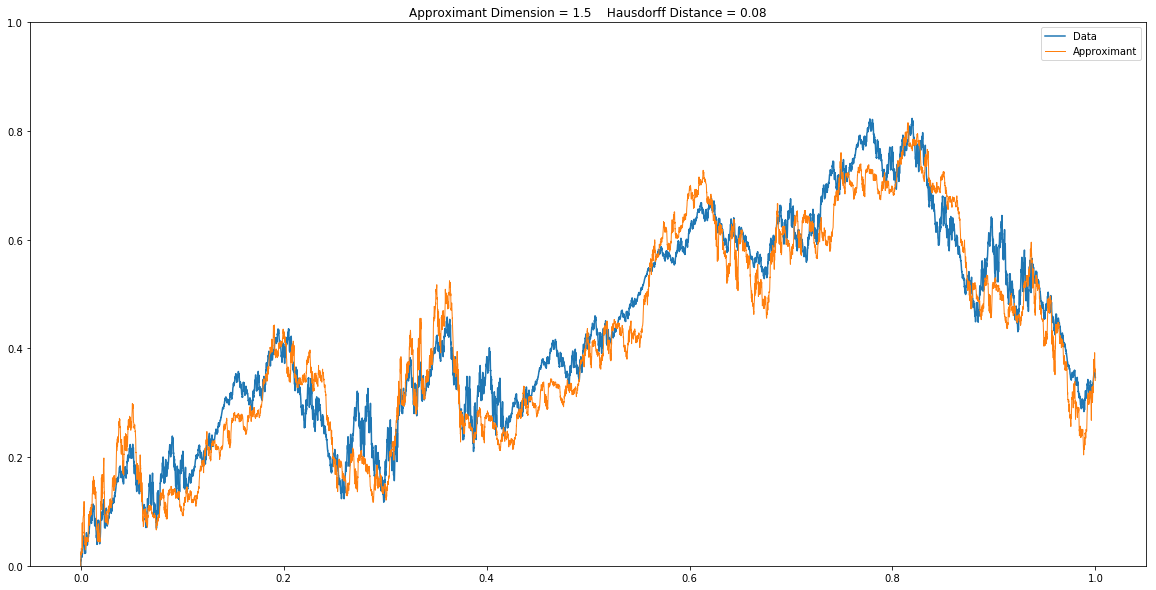

In [458]:
N = 16
D = 1.5

A,b = novel_apx(data,N,D)

Z = chaos(A, b ,p = None ,it =10000)

Z = Z[Z[:,0].argsort()]

dH = np.round(max(directed_hausdorff(data,Z)[0], directed_hausdorff(Z,data)[0]),3)

plt.figure(figsize = (20,10))

plt.plot(data[:,0],data[:,1], label = 'Data')

plt.ylim(0,1)
plt.plot(Z[:,0],Z[:,1], label = "Approximant",linewidth = 1)
plt.title("Approximant Dimension = " + str(D) +'    ' + 'Hausdorff Distance = ' + str(dH))

plt.legend()

print('Hausdorff Distance:')
print(dH)

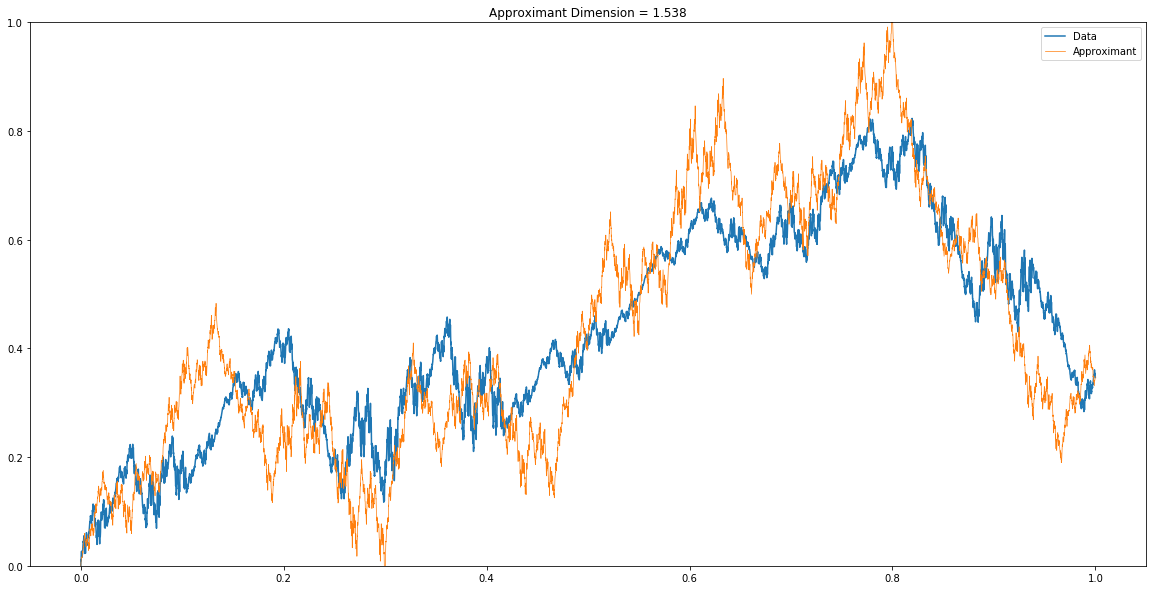

In [401]:

#plt.figure(figsize = (11,6))
plt.figure(figsize = (20,10))

plt.plot(data[:,0],data[:,1], label = 'Data')

plt.ylim(0,1)
plt.plot(Z6[:,0],Z6[:,1], label = "Approximant",linewidth = 0.7)
plt.title("Approximant Dimension = " + str(D_approx))
plt.legend()


In [402]:
max(directed_hausdorff(data,Z6)[0], directed_hausdorff(Z6,data)[0])

0.19628941179251216

In [404]:
directed_hausdorff(Z6,data)

(0.19628941179251216, 8091, 8194)

In [406]:
data[8194,:]

array([0.8194    , 0.82301309])

In [407]:
Z6[8091,:]

array([0.79994787, 1.01833628])